In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ko_dc = pd.read_csv('ko_figures/top50_degree_centrality_all_celltypes.csv')
ko_dc.head()

,cell_type,rank,gene,degree_centrality_all
0,Adipocyte,1,Zeb1,0.245322
1,Adipocyte,2,Ebf1,0.234927
2,Adipocyte,3,Stat1,0.209979
3,Adipocyte,4,Klf12,0.205821
4,Adipocyte,5,Tcf7l2,0.203742


In [3]:
wt_dc = pd.read_csv('wt_figures/top50_degree_centrality_all_celltypes.csv')
wt_dc.head()

,cell_type,rank,gene,degree_centrality_all
0,Adipocyte,1,Ebf1,0.229376
1,Adipocyte,2,Klf12,0.225352
2,Adipocyte,3,Zeb1,0.187123
3,Adipocyte,4,Tcf7l2,0.173038
4,Adipocyte,5,Klf4,0.152918


In [4]:
ko_cell_types = ko_dc['cell_type'].unique()
ko_cell_types

array(['Adipocyte', 'BasalEpi_Acta2+Trp63', 'Bcells', 'DCs',
       'Endothelials', 'Epi_Ctr9+', 'Epi_Kit+Elf5+', 'Epi_proliferating',
       'Fibroblasts', 'Myeloid_cells', 'Pericytes/SMC', 'SMC?',
       'Schwann?', 'Tcells'], dtype=object)

In [5]:
wt_cell_types = wt_dc['cell_type'].unique()
wt_cell_types

array(['Adipocyte', 'BasalEpi_Acta2+Trp63', 'Bcells', 'DCs',
       'Endothelials', 'Epi_Ctr9+', 'Epi_Kit+Elf5+', 'Epi_proliferating',
       'Fibroblasts', 'Myeloid_cells', 'Pericytes/SMC', 'SMC?',
       'Schwann?', 'Tcells'], dtype=object)

In [6]:
def place_labels_no_overlap(ax, genes, x_vals, y_vals, colors, fontsize=7):
    """Greedy label placement that avoids overlaps using the renderer bounding boxes."""
    fig = ax.get_figure()
    fig.canvas.draw()  # initialize renderer
    renderer = fig.canvas.get_renderer()
    
    # Candidate offsets (in points) to try for each label
    candidate_offsets = [
        (-35, 18), (18, -35),        # default: up-left, down-right
        (-35, -18), (18, 18),         # down-left, up-right
        (-50, 0), (25, 0),            # left, right
        (0, 25), (0, -35),            # up, down
        (-50, 30), (30, -50),         # far up-left, far down-right
        (-50, -30), (30, 30),         # far down-left, far up-right
        (-60, 10), (40, -10),         # extra far
    ]
    placed_bboxes = []  # display-coord bounding boxes of already-placed labels
    
    for g in genes:
        color = colors[g]
        best_offset = candidate_offsets[0]
        best_overlap = float('inf')
        
        for offset in candidate_offsets:
            # Create a temporary annotation to measure its bbox
            ann = ax.annotate(g, (x_vals[g], y_vals[g]),
                              textcoords='offset points', xytext=offset,
                              fontsize=fontsize, fontweight='bold', color=color,
                              arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5, lw=0.5))
            fig.canvas.draw_idle()
            bb = ann.get_window_extent(renderer)
            
            # Compute total overlap area with already-placed labels
            total_overlap = 0
            for pb in placed_bboxes:
                # Intersection
                x_overlap = max(0, min(bb.x1, pb.x1) - max(bb.x0, pb.x0))
                y_overlap = max(0, min(bb.y1, pb.y1) - max(bb.y0, pb.y0))
                total_overlap += x_overlap * y_overlap
            
            ann.remove()
            
            if total_overlap == 0:
                best_offset = offset
                best_overlap = 0
                break
            elif total_overlap < best_overlap:
                best_overlap = total_overlap
                best_offset = offset
        
        # Place final annotation with best offset
        ann = ax.annotate(g, (x_vals[g], y_vals[g]),
                          textcoords='offset points', xytext=best_offset,
                          fontsize=fontsize, fontweight='bold', color=color,
                          arrowprops=dict(arrowstyle='-', color='grey', alpha=0.5, lw=0.5))
        fig.canvas.draw_idle()
        placed_bboxes.append(ann.get_window_extent(renderer))

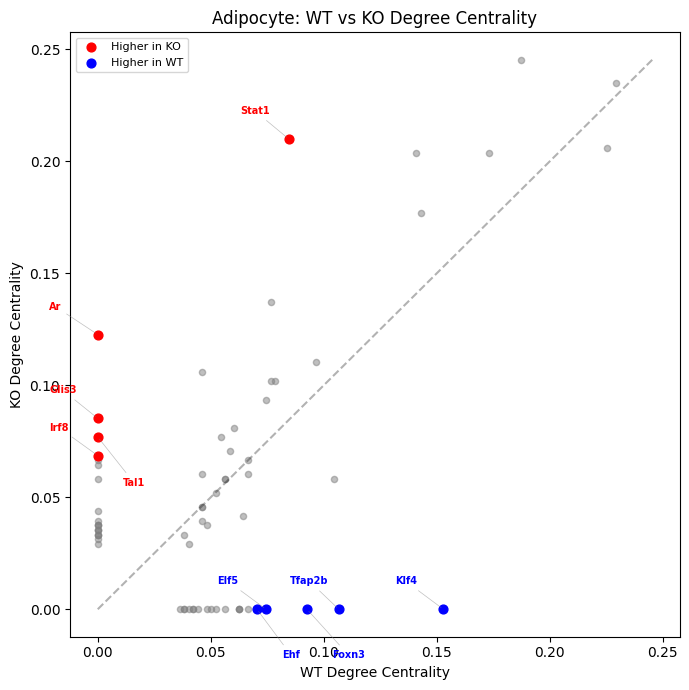

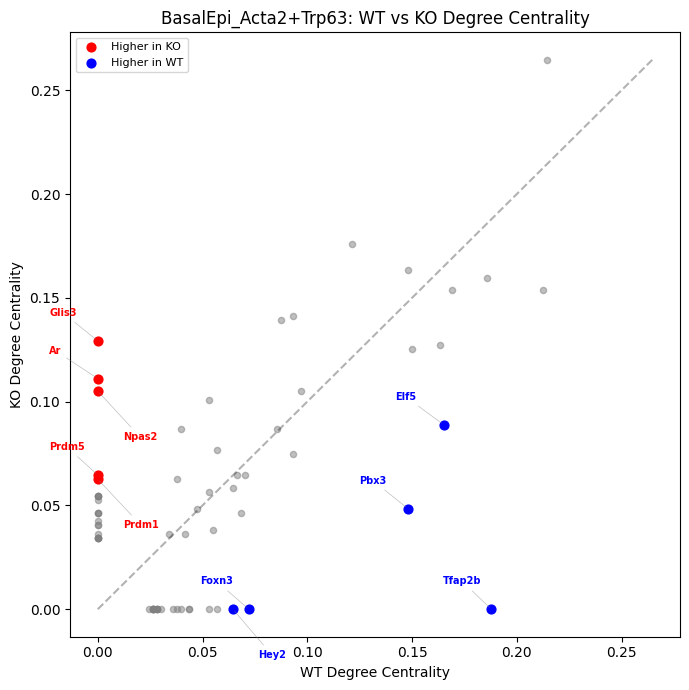

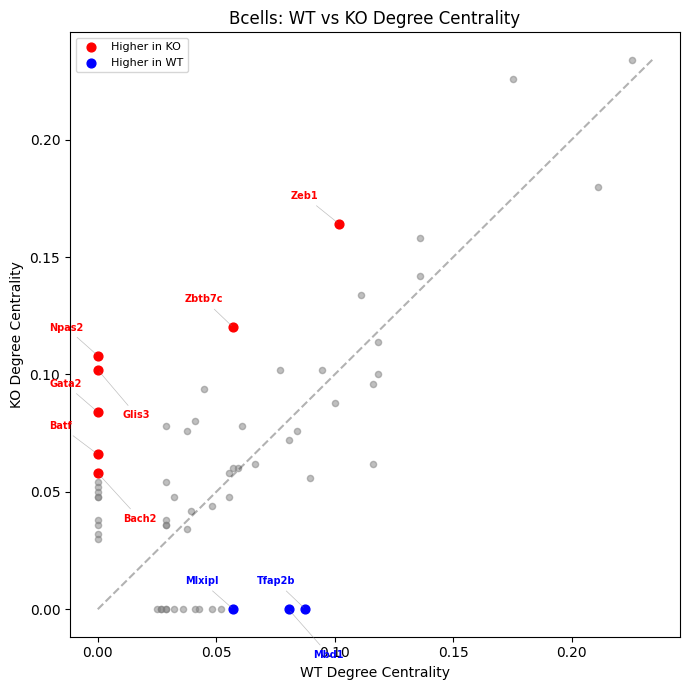

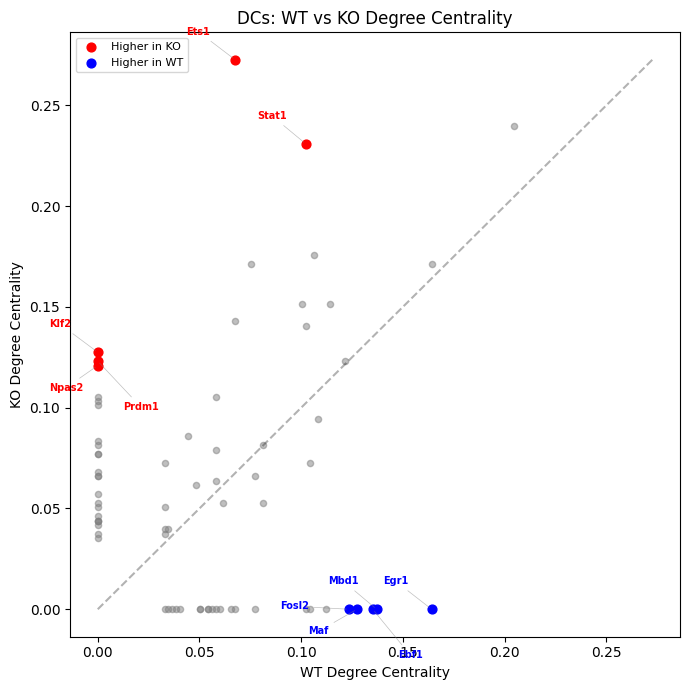

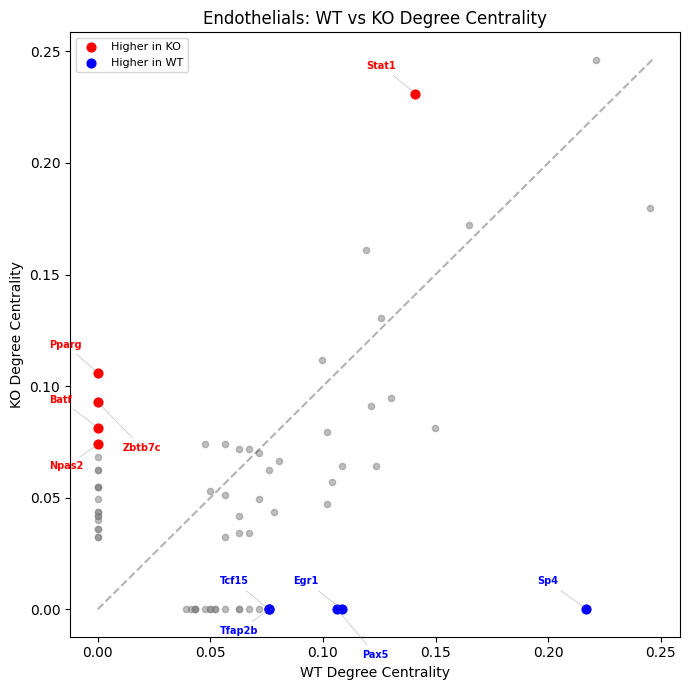

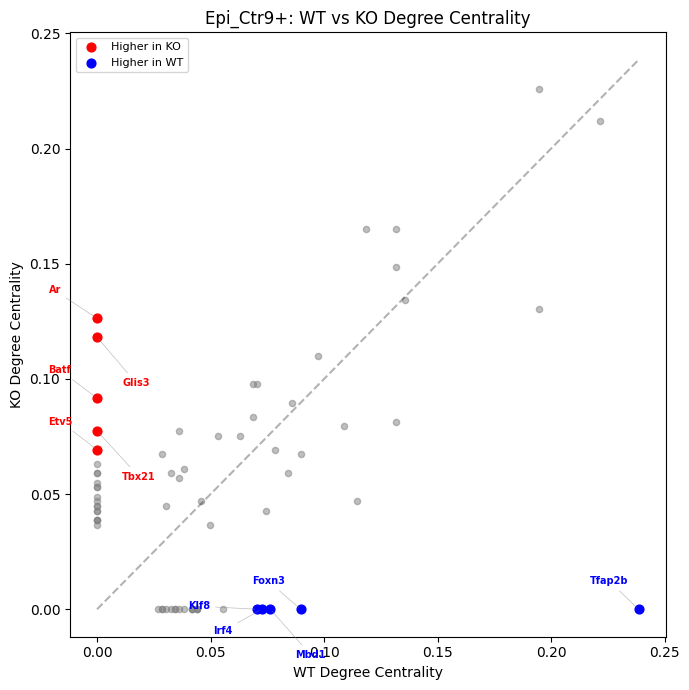

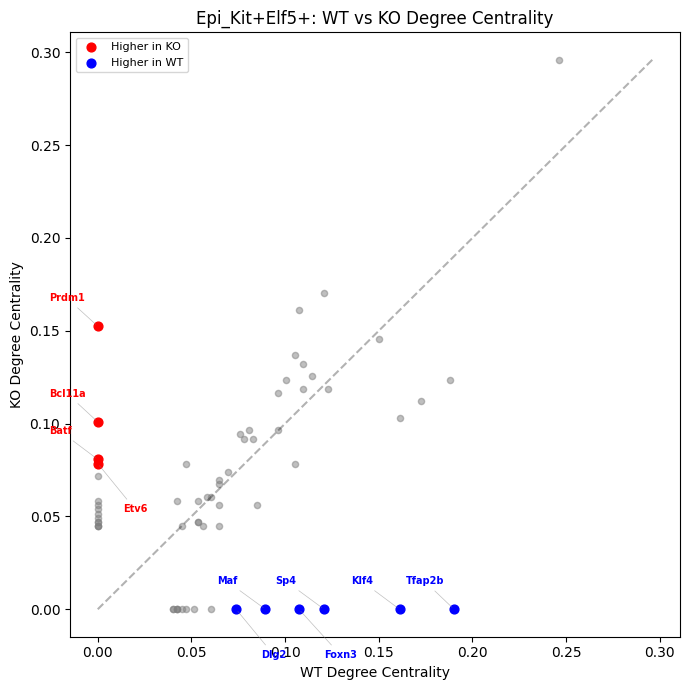

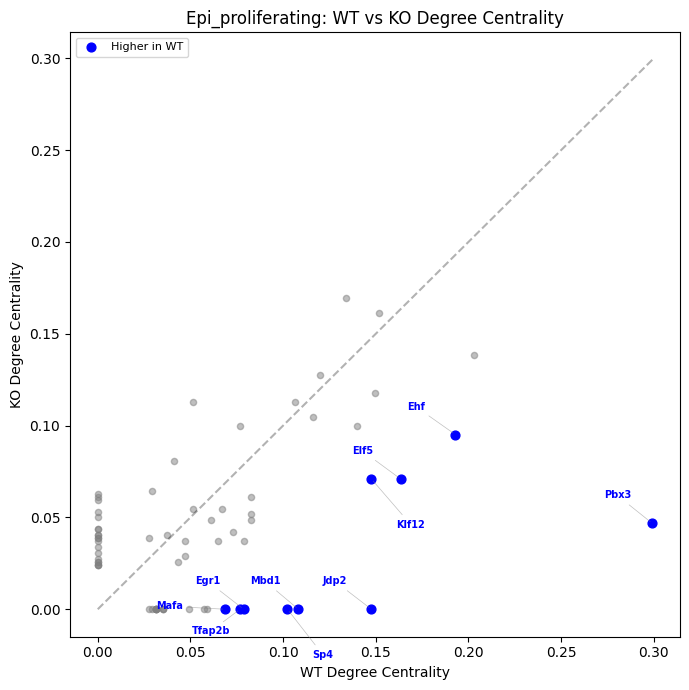

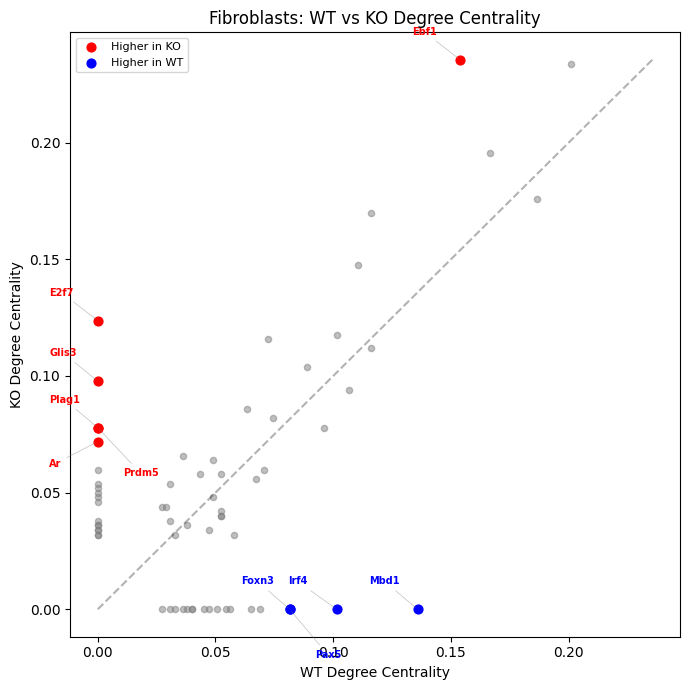

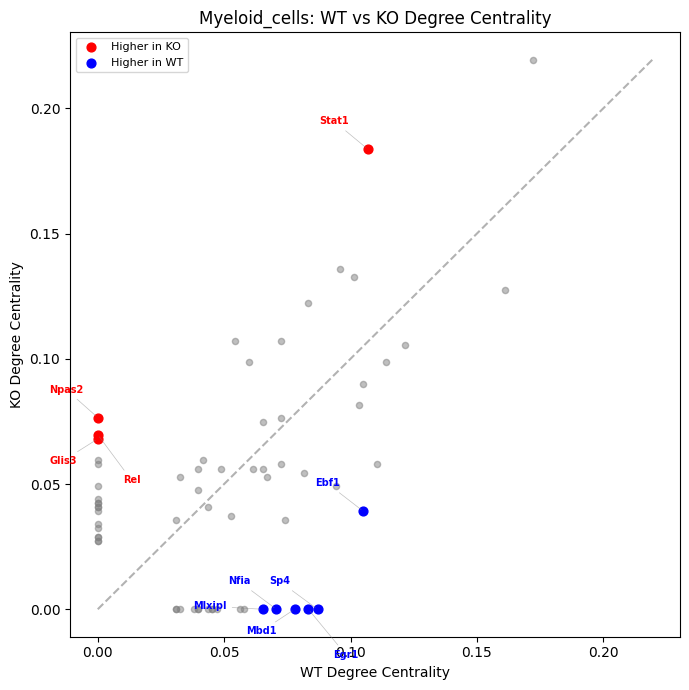

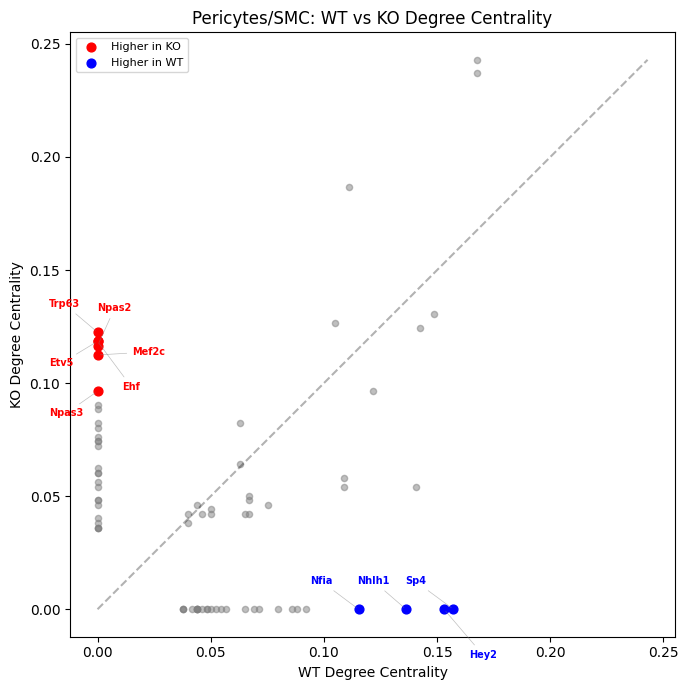

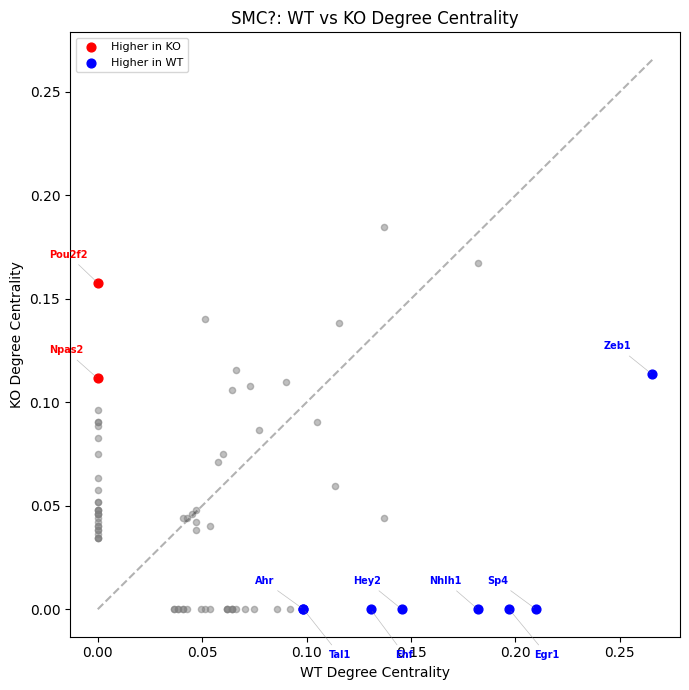

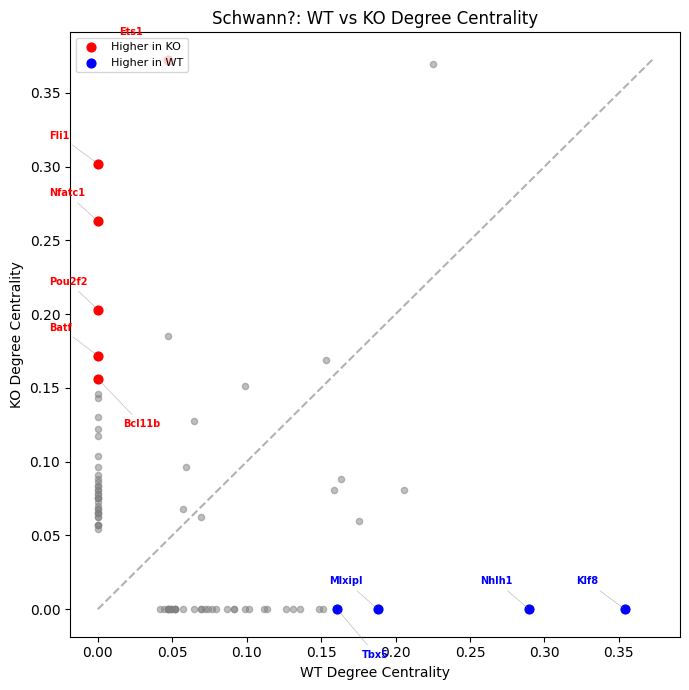

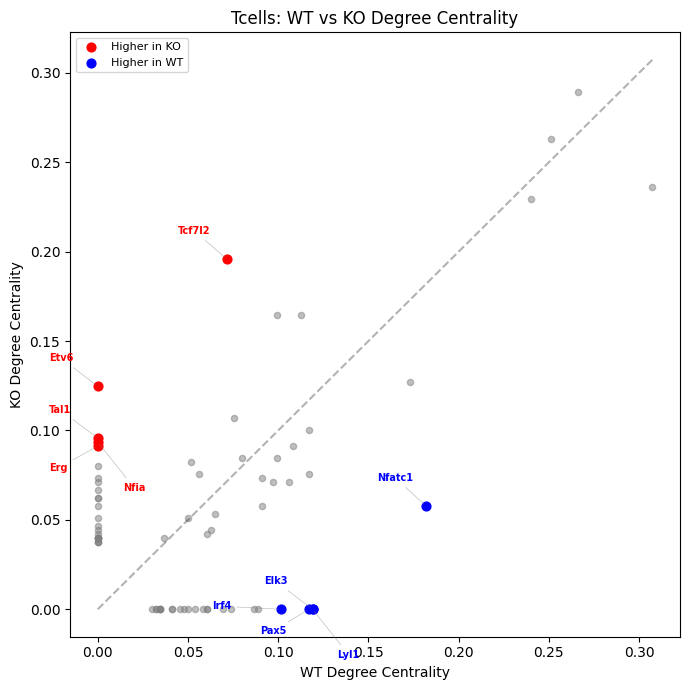

In [7]:
for ct in ko_cell_types:
    
    ko_ct = ko_dc[ko_dc['cell_type'] == ct].set_index('gene')['degree_centrality_all']
    wt_ct = wt_dc[wt_dc['cell_type'] == ct].set_index('gene')['degree_centrality_all']
    
    # union of genes from both conditions
    common_genes = ko_ct.index.union(wt_ct.index)
    # align on common genes, fill missing with 0
    ko_vals = ko_ct.reindex(common_genes, fill_value=0)
    wt_vals = wt_ct.reindex(common_genes, fill_value=0)
    # deviation from diagonal
    diff = ko_vals - wt_vals
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(wt_vals, ko_vals, alpha=0.5, s=20, color='grey')

    # Identify off-diagonal TFs: top N by absolute deviation from diagonal
    n_label = 10
    off_diag_genes = diff.abs().nlargest(n_label).index
    # Color off-diagonal points: red = higher in KO, blue = higher in WT
    ko_higher = [g for g in off_diag_genes if diff[g] > 0]
    wt_higher = [g for g in off_diag_genes if diff[g] < 0]
    
    if ko_higher:
        ax.scatter(wt_vals[ko_higher], ko_vals[ko_higher], color='red', s=40, zorder=3, label='Higher in KO')
    if wt_higher:
        ax.scatter(wt_vals[wt_higher], ko_vals[wt_higher], color='blue', s=40, zorder=3, label='Higher in WT')
    
    # Build color dict and place labels with collision avoidance
    label_colors = {g: ('red' if diff[g] > 0 else 'blue') for g in off_diag_genes}
    place_labels_no_overlap(ax, off_diag_genes, wt_vals, ko_vals, label_colors)

    max_val = max(wt_vals.max(), ko_vals.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    
    ax.set_xlabel('WT Degree Centrality')
    ax.set_ylabel('KO Degree Centrality')
    ax.set_title(f'{ct}: WT vs KO Degree Centrality')
    ax.legend(fontsize=8, loc='upper left')
    plt.tight_layout()
    safe_name = ct.replace("/", "_")
    plt.savefig(f"ko_wt_dc_comparison/{safe_name}.png", dpi=150)
    plt.show()